<a href="https://colab.research.google.com/github/superp0tat0/PlayGround/blob/master/CIFAR10_Spectral_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

import tensorflow as tf
from keras.datasets import mnist
from keras.datasets import cifar10 
from keras.models import Sequential  # Model type to be used

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# import some additional tools
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization

def model_status(model):
    for layer in model.layers:
      print(layer, layer.trainable)

def build_model_single_dense(first_layer_neuron = 32):
  model = Sequential()                                 # Linear stacking of layers
  model.add(Dense(first_layer_neuron))                
  model.add(Activation('relu'))                     # relu activation

  model.add(Dense(10))                                 # final 10 FCN nodes
  model.add(Activation('softmax'))                     # softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# PCA transfer learning on CIFAR10 Datasets

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# X_train = np.mean(X_train, axis = -1)
# X_test = np.mean(X_test, axis = -1)

X_train_Flatten1 = X_train.reshape(50000, 32*32)
X_test_Flatten = X_test.reshape(10000, 32*32)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
y_random = np.array([random.randint(0,9) for i in range(50000)])
Y_random = np_utils.to_categorical(y_random, nb_classes)

ValueError: ignored

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train_Flatten1 = X_train[:,:,:,0].reshape(50000, 32*32)
X_train_Flatten2 = X_train[:,:,:,1].reshape(50000, 32*32)
X_train_Flatten3 = X_train[:,:,:,2].reshape(50000, 32*32)

obj_PCA = PCA(n_components= 128)

In [ ]:
obj_PCA.fit(X_train_Flatten1)
pcs1 = obj_PCA.components_.reshape(128,32,32,1)

obj_PCA.fit(X_train_Flatten2)
pcs2 = obj_PCA.components_.reshape(128,32,32,1)

obj_PCA.fit(X_train_Flatten3)
pcs3 = obj_PCA.components_.reshape(128,32,32,1)
print(pcs1.shape)

(128, 32, 32, 1)


In [ ]:
pcs = np.concatenate((pcs1, pcs2, pcs3), axis=-1)
print(pcs.shape)

(128, 32, 32, 3)


In [ ]:
print(pcs1[i,:,:].shape)

(32, 32, 1)


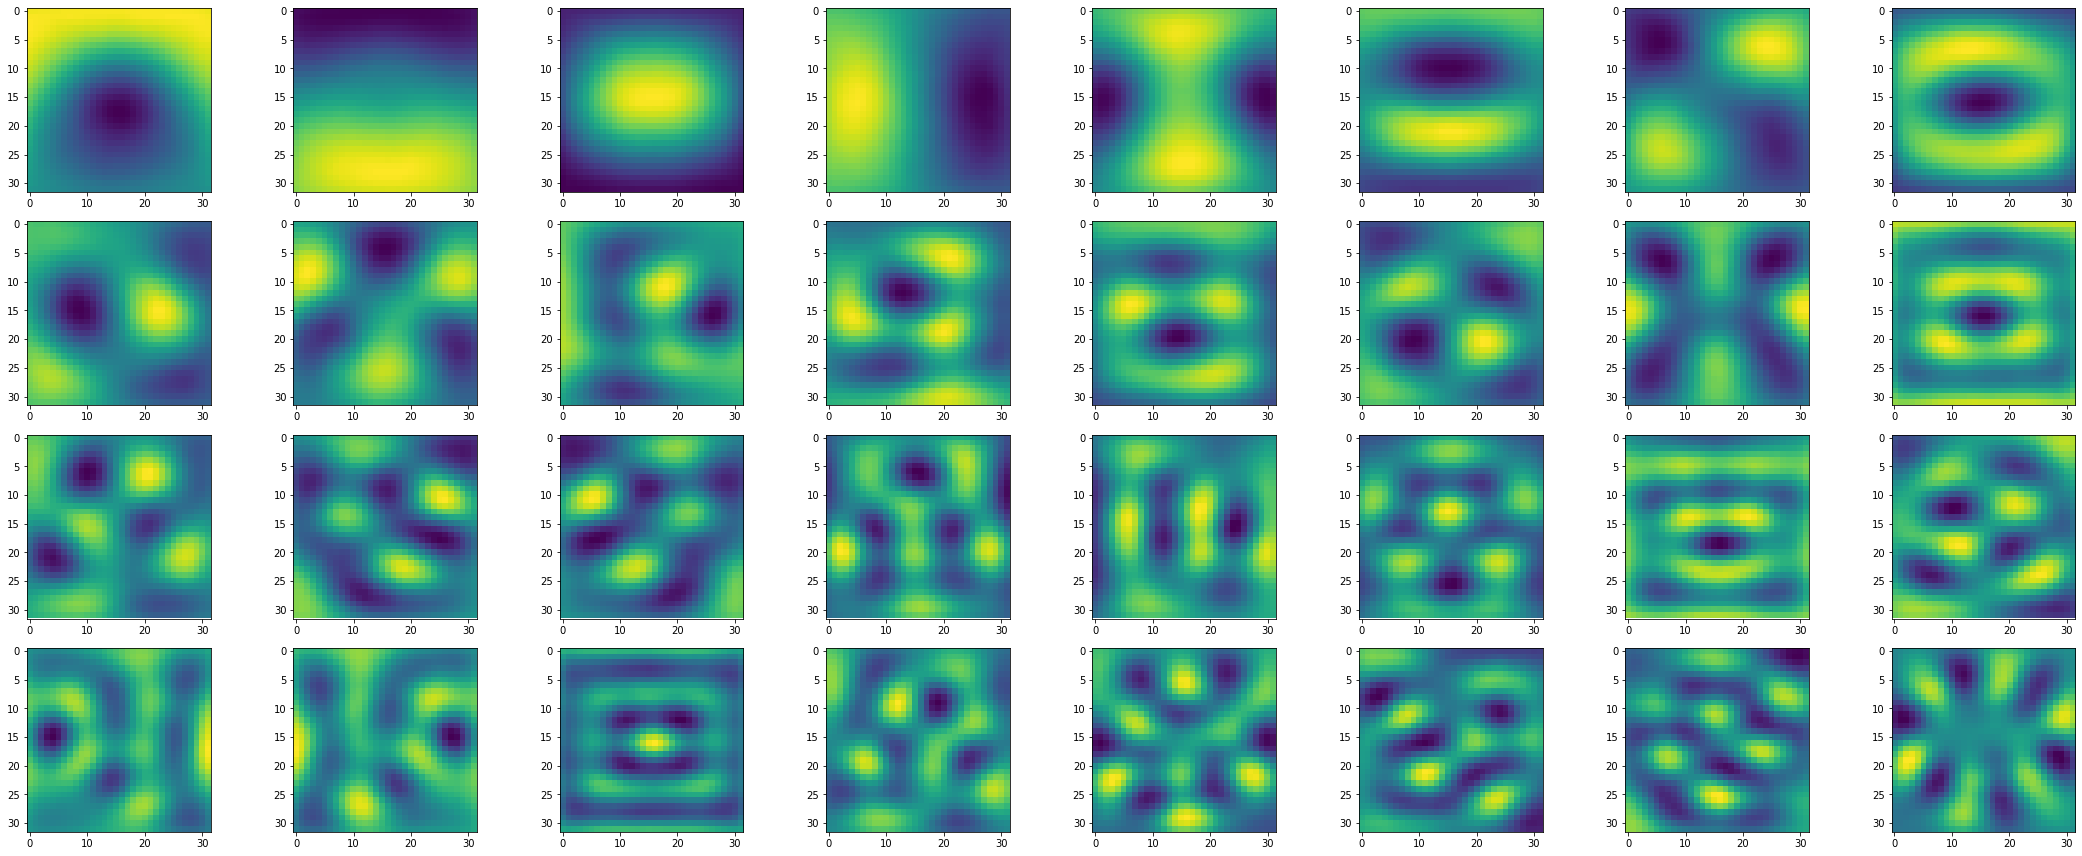

In [ ]:
plt.rcParams['figure.figsize'] = (30,12) # Make the figures a bit bigger

for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(pcs3[i,:,:].reshape(32,32), interpolation='none')
    
plt.tight_layout()

In [ ]:
# Treat the new PCs as the weights.
new_X_train = X_train_Flatten @ obj_PCA.components_.T
new_X_test = X_test_Flatten @ obj_PCA.components_.T
print(new_X_train.shape)
print(new_X_test.shape)

(50000, 128)
(10000, 128)


In [ ]:
pca_model = build_model_single_dense(256)
pca_history = pca_model.fit(x=new_X_train, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(new_X_test, Y_test))

In [ ]:
naive_dense = build_model_single_dense(256)
naive_history = naive_dense.fit(x=X_train_Flatten, y=Y_train, epochs=50, steps_per_epoch=100, validation_data=(X_test_Flatten, Y_test))

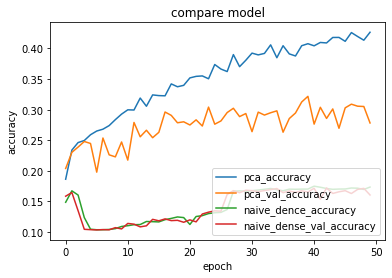

In [ ]:
%matplotlib inline
plt.plot(pca_history.history['accuracy'])
plt.plot(pca_history.history['val_accuracy'])
plt.plot(naive_history.history['accuracy'])
plt.plot(naive_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pca_accuracy', 'pca_val_accuracy', 'naive_dence_accuracy', 'naive_dense_val_accuracy'], loc='lower right')
plt.show()

In [ ]:
X_unlabel, X_label, y_unlabel, y_label = train_test_split(X_train, y_train, test_size = 0.5)
X_unlabel_Flatten = X_unlabel.reshape(25000, 32*32)
X_label_Flatten = X_label.reshape(25000, 32*32)

Y_unlabel = np_utils.to_categorical(y_unlabel, nb_classes)
Y_label = np_utils.to_categorical(y_label, nb_classes)

In [ ]:
unlabel_pca_obj = PCA(n_components=128)
unlabel_pca_obj.fit(X_unlabel_Flatten)

transfer_label_X = X_label_Flatten @ unlabel_pca_obj.components_.T
transfer_label_X_test = X_test_Flatten @ unlabel_pca_obj.components_.T

In [ ]:
transfer_pca_model = build_model_single_dense(256)
pretrain_pca_history = transfer_pca_model.fit(x=transfer_label_X, y=Y_label, epochs=50, steps_per_epoch=100, validation_data=(transfer_label_X_test, Y_test))

In [ ]:
naive_dense = build_model_single_dense(256)
naive_dense_history = naive_dense.fit(x=X_label_Flatten, y = Y_label, epochs=50, steps_per_epoch=20, validation_data=(X_test_Flatten, Y_test))

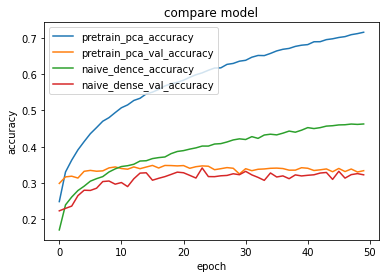

In [ ]:
%matplotlib inline
plt.plot(pretrain_pca_history.history['accuracy'])
plt.plot(pretrain_pca_history.history['val_accuracy'])
plt.plot(naive_dense_history.history['accuracy'])
plt.plot(naive_dense_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pretrain_pca_accuracy', 'pretrain_pca_val_accuracy', 'naive_dence_accuracy', 'naive_dense_val_accuracy'], loc='upper left')
plt.show()

# VGG16 Pre-train on CIFAR 10 empricial study

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)
# X_train = np.mean(X_train, axis = -1)
# X_test = np.mean(X_test, axis = -1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
y_random = np.array([random.randint(0,9) for i in range(50000)])
Y_random = np_utils.to_categorical(y_random, nb_classes)

(50000, 32, 32, 3)


In [ ]:
def build_VGG16():
  model = VGG16(include_top = False, input_shape = [32,32,3], weights="imagenet")
  x = Flatten()(model.output)
  x = Dense(1024, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dense(512, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dense(256, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dense(128, activation="relu")(x)
  x = BatchNormalization()(x)
  x = Dense(64, activation="relu")(x)
  x = BatchNormalization()(x)
  predictions = Dense(nb_classes, activation="softmax")(x)

  VGG16_model = Model(inputs = model.input, outputs = predictions)
  VGG16_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

  return VGG16_model

In [ ]:
print(VGG16_model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
history = VGG16_model.fit(x=X_train, y=Y_random, epochs=120, steps_per_epoch=100)

Epoch 1/120
100/100 [==============================] - 7s 52ms/step - loss: 2.7404 - accuracy: 0.0989
Epoch 2/120
100/100 [==============================] - 5s 52ms/step - loss: 2.3658 - accuracy: 0.1064
Epoch 3/120
100/100 [==============================] - 5s 52ms/step - loss: 2.3263 - accuracy: 0.1086
Epoch 4/120
100/100 [==============================] - 5s 53ms/step - loss: 2.3132 - accuracy: 0.1132
Epoch 5/120
100/100 [==============================] - 5s 52ms/step - loss: 2.3046 - accuracy: 0.1184
Epoch 6/120
100/100 [==============================] - 5s 52ms/step - loss: 2.2977 - accuracy: 0.1233
Epoch 7/120
100/100 [==============================] - 5s 52ms/step - loss: 2.2910 - accuracy: 0.1306
Epoch 8/120
100/100 [==============================] - 5s 52ms/step - loss: 2.2861 - accuracy: 0.1348
Epoch 9/120
100/100 [==============================] - 5s 52ms/step - loss: 2.2804 - accuracy: 0.1381
Epoch 10/120
100/100 [==============================] - 5s 52ms/step - loss: 2.275

In [ ]:
for layer in VGG16_model.layers[:]:
  layer.trainable = False

for i in range(-11, 0):
  VGG16_model.layers[i].trainable= True

model_status(VGG16_model)

real_VGG16 = build_VGG16()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc066491fd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc066491278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc06647d710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc0664dc198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc0661252e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc066125cf8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc05440ebe0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc0547a4e48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc0547e0b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc066195978> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc0d05fbd30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
random_history = VGG16_model.fit(x=X_test, y=Y_test, epochs=80, steps_per_epoch=80, validation_split=0.2)

Epoch 1/80
80/80 [==============================] - 3s 26ms/step - loss: 2.6333 - accuracy: 0.1786 - val_loss: 10.3351 - val_accuracy: 0.1065
Epoch 2/80
80/80 [==============================] - 2s 22ms/step - loss: 1.9759 - accuracy: 0.2196 - val_loss: 4.5559 - val_accuracy: 0.1445
Epoch 3/80
80/80 [==============================] - 2s 23ms/step - loss: 1.9323 - accuracy: 0.2185 - val_loss: 3.2721 - val_accuracy: 0.1995
Epoch 4/80
80/80 [==============================] - 2s 22ms/step - loss: 1.8893 - accuracy: 0.2404 - val_loss: 3.6494 - val_accuracy: 0.1360
Epoch 5/80
80/80 [==============================] - 2s 22ms/step - loss: 1.8716 - accuracy: 0.2411 - val_loss: 2.8309 - val_accuracy: 0.1810
Epoch 6/80
80/80 [==============================] - 2s 22ms/step - loss: 1.8443 - accuracy: 0.2511 - val_loss: 2.6095 - val_accuracy: 0.1505
Epoch 7/80
80/80 [==============================] - 2s 22ms/step - loss: 1.8178 - accuracy: 0.2616 - val_loss: 2.8585 - val_accuracy: 0.1625
Epoch 8/80
8

In [ ]:
real_history = real_VGG16.fit(x=X_test, y=Y_test, epochs=80, steps_per_epoch=80, validation_split=0.2)

Epoch 1/80
80/80 [==============================] - 3s 26ms/step - loss: 2.5127 - accuracy: 0.1559 - val_loss: 2.5347 - val_accuracy: 0.1420
Epoch 2/80
80/80 [==============================] - 2s 22ms/step - loss: 1.9349 - accuracy: 0.2391 - val_loss: 2.3231 - val_accuracy: 0.1815
Epoch 3/80
80/80 [==============================] - 2s 22ms/step - loss: 1.8622 - accuracy: 0.2596 - val_loss: 4.9249 - val_accuracy: 0.1570
Epoch 4/80
80/80 [==============================] - 2s 22ms/step - loss: 1.8155 - accuracy: 0.2710 - val_loss: 2.9325 - val_accuracy: 0.2265
Epoch 5/80
80/80 [==============================] - 2s 22ms/step - loss: 1.6964 - accuracy: 0.3316 - val_loss: 4.6109 - val_accuracy: 0.1120
Epoch 6/80
80/80 [==============================] - 2s 22ms/step - loss: 1.5197 - accuracy: 0.4053 - val_loss: 3.2907 - val_accuracy: 0.1155
Epoch 7/80
80/80 [==============================] - 2s 22ms/step - loss: 1.4218 - accuracy: 0.4573 - val_loss: 2.6144 - val_accuracy: 0.2750
Epoch 8/80
80

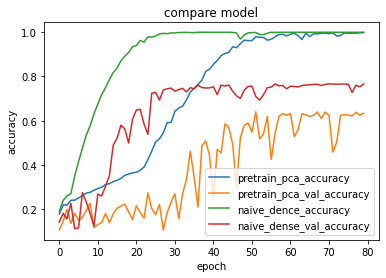

In [ ]:
%matplotlib inline
plt.plot(random_history.history['accuracy'])
plt.plot(random_history.history['val_accuracy'])
plt.plot(real_history.history['accuracy'])
plt.plot(real_history.history['val_accuracy'])
plt.title('compare model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pretrain_pca_accuracy', 'pretrain_pca_val_accuracy', 'naive_dence_accuracy', 'naive_dense_val_accuracy'], loc='lower right')
plt.show()